# **IFN712 TRANSFER LEARNING FOR HAMA OBJECT CLASSIFICATION**
**Date: 29/10/2022**
**Train with HamaDataset_9327_images**
**Van Vu KIEU**

In [ ]:
import os
import cv2                          # for image loading and colour conversion
import glob
import math
import numpy as np      
from PIL import Image            # for reshaping, array manipulation
import matplotlib.pyplot as plt     # for plotting
import keras
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, load_img, img_to_array
# tensorflow
import tensorflow as tf  
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.applications import MobileNetV2
# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Global variables**

In [ ]:
# default image size and shape
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
# path to the folder contains the hama dataset
PATH_TO_DATASET = "/content/drive/MyDrive/IFN712_project/Hama_classification/HamaDataset_9372_images"

In [ ]:
# number of types of hama objects
NUM_CLASSES = 13

In [ ]:
# global FULL_MOBILENETV2, NO_TOP_MOBILENETV2, BASE_MODEL, MODEL
# global X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, X_TEST, Y_TEST, CLASSES

# **1. Statistics of the dataset**

In [ ]:
def dataset_statistic(path_to_dataset):
  '''
  This function print out the statistic of the dataset, and display one sample image
  @param path_to_dataset: absolute path to the dataset
  
  '''
  # extension of images
  ext = ('.jpg', '.png')
  # A dictionary of sample images
  sample_images = {}
  # total images and classes
  total_image = 0
  classes = 0
  # iterate through the dataset
  for folder in os.listdir(path_to_dataset):
      classes += 1
      # absolute file name
      file_name = ""
      # number of images in this class
      num_img = 0
      # absolute directory name
      sub_dir = os.path.join(path_to_dataset, folder)
      # count the number of images in this folder
      for file in os.listdir(sub_dir):
          if file.endswith(ext):
              if file_name == "":
                  file_name = os.path.join(sub_dir, file)
                  sample_images[folder] = Image.open(file_name)
              num_img += 1
          else:
              continue
      print(f"Class {folder}: {num_img} images.")
      total_image += num_img
  print(f"There are total {total_image} images and {classes} classes in this dataset.")
  # display the example image
  # prepare to plot
  fig = plt.figure(figsize=(10, 10))
  # number of rows and columns in this plot
  columns = 2
  if len(sample_images) % columns:
      rows = len(sample_images) / columns + 1
  else:
      rows = len(sample_images) / columns
  i = 1
  # plot all sample images
  for object_name, img in sample_images.items():
      ax = fig.add_subplot(rows, columns, i)
      ax.imshow(img)
      ax.set_title(object_name)
      ax.axis('off')
      i += 1
  plt.show()
   


DATASET STATISTIC:

Class Hama_Fish: 688 images.
Class Hama_Shushi_1: 753 images.
Class Hama_Red_Duck: 666 images.
Class Hama_Shushi_2: 705 images.
Class Hama_Smile: 654 images.
Class Hama_Panda: 756 images.
Class Hama_Apple: 766 images.
Class Hama_Pink_House: 717 images.
Class Hama_Blue_Duck: 722 images.
Class Hama_Bear: 620 images.
Class Hama_Strawberry: 917 images.
Class Hama_Yellow_Duck: 728 images.
Class Hama_Sunglasses: 680 images.
There are total 9372 images and 13 classes in this dataset.


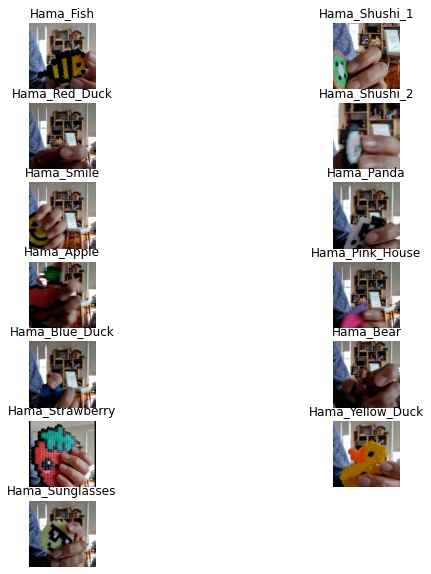

In [ ]:
print("\nDATASET STATISTIC:\n")
dataset_statistic(PATH_TO_DATASET)

# **2. Download the pretrained MobileNetV2 network**

Referance:
https://keras.io/api/applications/mobilenet/

In [ ]:
def download_model(input_shape, include_top):
  """
  This function download MobileNetV2 model with or without the last layer
  @param input_shape: input shape of the model
  @param include_top: with or without the last layer
  
  @return: a MobileNetV2 instance
  """
  return MobileNetV2(input_shape = input_shape, weights='imagenet', include_top=include_top, pooling = 'avg')

In [ ]:
def test_download_model():
  '''
  This function downloads MobileNetV2 model with and without the lastlayer, 
  and gives summaries of them
  '''    
  print("\n TEST download_model() function")

  # download the entire model
  full_model = download_model(IMAGE_SHAPE, True)
  # download the model without the last layer
  headless_model = download_model(IMAGE_SHAPE, False)
  # summaries of two models
  # entire model:
  full_model.summary()  
  # headless model:
  headless_model.summary()
  # keras.utils.plot_model(headless_model, show_shapes=True)

In [ ]:
test_download_model()


 TEST download_model() function
9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']  

# **3.  Replace the last layer of the MobleNetV2 with a Dense layer**

Reference: https://keras.io/guides/transfer_learning/

In [ ]:
def replace_last_by_Dense(base_model, input_shape, num_classes):
  """
  This function replaces the last layer of a MobileNetV2 with a Dense layer,
  which can classify all classes of objects in the dataset
  @param base_model: a headless pretrained model
  @param input_shape: input shape of the model
  @param num_classes: number of classes 

  @return: a new model
  """
  # Freeze base model
  base_model.trainable = False

  # create a new model on top of the base_model
  inputs = keras.Input(shape=input_shape, name='input_layer')
  x = base_model(inputs, training=False)
  # This layer replaces the last layer in the base_model
  outputs = keras.layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
  # form a new model
  model = keras.Model(inputs, outputs)

  return model

In [ ]:
def test_replace_last_by_Dense():
  '''
  This function replaces the last layer of the downloaded MobileNetV2 network 
  with a Dense layer and build a new model on top of this model
  '''
  print("\n TEST replace_last_by_Dense() function")

  # base model is a MobileNetV2 without top layer 
  base_model = download_model(IMAGE_SHAPE, False)
  # new model after replace the last layer of the base_model
  model = replace_last_by_Dense(base_model, IMAGE_SHAPE, NUM_CLASSES)

  # summary of the new model
  model.summary()
  keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)


In [ ]:
test_replace_last_by_Dense()


 TEST replace_last_by_Dense() function
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 output_layer (Dense)        (None, 13)                16653     
                                                                 
Total params: 2,274,637
Trainable params: 16,653
Non-trainable params: 2,257,984
_________________________________________________________________


# **4. Prepare training, validation and test set**

In [ ]:
# Prepare image ready for prediction or training
def prepare_image(file_name, target_size):    
    '''
    This function uses keras.preprocessing to load an image from a directory,
    then convert it into numpy array.
    @param file_name: absolute name of an image file
    @param target_size: target image size
    @return:  an array, which is scaled to [-1, 1], represents an image.
    '''
    # print(file_name)   
    # using keras's preprocessing image to load, resize and convert an image to an array
    img = load_img(file_name, target_size=target_size) 
    img_array = img_to_array(img)     
    # using preprocess_input to scaled the array to [-1, 1] before returning
    return tf.keras.applications.mobilenet.preprocess_input(img_array)
    # We can use another way to rescale:
    # rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
    # https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:

def load_dataset(path_to_dataset, target_size):
  '''
  This function gets images from the dataset, prepares images for training
  @param path_to_dataset:
  @param target_size: target image size
  @return: image data, classes in integer format, classes in string format
  '''
  # extension of images
  ext = ('.jpg','.png')
  # list of image data in numpy array format
  X = []
  # list of classes in integer format
  Y = []
  # list of classes with string format
  classes = []
  # iterate through subfolders in the dataset
  i = 0
  for subfolder in os.listdir(path_to_dataset):
    # add this subfolder, which is the class name, into classes list
    classes.append(subfolder)
    # absolute directory name
    sub_dir = os.path.join(path_to_dataset, subfolder)
    # print(sub_dir)
    # iterate through the subfolder to process  every images          
    for file in os.listdir(sub_dir):
        if file.endswith(ext):
          file_name = os.path.join(sub_dir, file)   
          # print(file_name)     
          # preprocess the image and add it to image data list
          X.append(prepare_image(file_name, target_size))
          # add an integer value to the list
          Y.append(i)
        else:
          continue
    i +=1  
  return np.array(X), np.array(Y), classes




**70% training, 15% for validation, 15% for testing**

References: 

https://www.v7labs.com/blog/train-validation-test-set

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
def tran_val_test_gen(data, classes, val_size=0.15, test_size=0.15, shuffle = True, random_state = 42):
  '''
  This function generates the training, validation and test sets 
  @param data: image data 
  @param classes: classes of image 
  @param val_size: the ratio of validation dataset
  @param test_size: the ratio of test dataset
  @param shuffle: shuffle the dataset
  @param random_state: 42

  @return: train, valiation, and test set
  '''
  # ratio of dataset for assessment the model
  assess_size = val_size + test_size
  # keep assess_size for assessment
  X_train, X_assess, Y_train, Y_assess = train_test_split(data, classes, test_size = assess_size, random_state = random_state, shuffle = shuffle) 
  # generate dataset for every validation and test sets
  test_ratio = test_size/assess_size
  X_val, X_test, Y_val, Y_test = train_test_split(X_assess, Y_assess, test_size = test_ratio, random_state = random_state, shuffle = shuffle) 
  return X_train, Y_train, X_val, Y_val, X_test, Y_test


**test generating dataset function**

In [ ]:
def test_tran_val_test_gen():
  '''
  This function prepare training, validation, and test sets
  '''  
  print("\n TEST tran_val_test_gen() function")
  # load, preprocess images from the dataset
  X, Y, classes = load_dataset(PATH_TO_DATASET, IMAGE_SIZE)
  # generate training, validation and test sets
  X_train, Y_train, X_val, Y_val, X_test, Y_test = tran_val_test_gen(X, Y)  
  # display some statistic
  print(f"There are {len(classes)} classes, and {len(X)} images in this dataset.")
  print(f"{len(X_train)} for training.")
  print(f"{len(X_val)} for validation.")
  print(f"{len(X_test)} for testing.")

In [ ]:
test_tran_val_test_gen()


 TEST tran_val_test_gen() function
There are 13 classes, and 9372 images in this dataset.
6560 for training.
1406 for validation.
1406 for testing.


# **5. Compile and train the model with an SGD optimizer**

Reference: https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy


In [ ]:
# compile the model
def compile_model(model, loss, metric, learning_rate=0.01, momentum=0):
    """
    This function compiles a model
    @param model: classification model
    @param loss: loss function
    @param metric: accuracy metric
    @param learning_rate: rate of learning
    @param momentum: momentum
    @return: a compiled model
    """
    model.compile(loss=loss,
                  optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False),
                  metrics=[metric])
    return model

In [ ]:
# train the model
def train_model(model, X_train, Y_train,  X_val, Y_val, es, batch_size = 20, epochs = 50 ):
  '''
  This function is used to train the model
  @param X_train: training set
  @param Y_train: classes 
  @param batch_size: batch size of data
  @param epochs: number of iteration
  @param X_val: validation set
  @param Y_val: classes
  @param es: early stoping setting
  @return: the trained model, history of training
  '''
  # fit model
  history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                      batch_size = batch_size, epochs = epochs, verbose=1, callbacks=[es])
  return model, history

**Plotting**

https://neptune.ai/blog/keras-metrics

In [ ]:
# plot errors
def plot_errors(history, learning_rate, momentum):
  '''
  This function plots the training and validation errors  
  @param history: the history of fitting the model
  @param learning_rate: learning rate
  @param momentum: momentum
  '''
  fig = plt.figure(figsize=[6, 6])  
  # a figure with a single Axes
  ax = fig.add_subplot()
  ax.plot(history['loss'], label='Train Error')
  ax.plot(history['val_loss'], label='Validation Error')  
  ax.set_ylabel("errors")
  ax.set_xlabel("epochs")
  ax.legend()
  ax.set_title(f'Errors of the model with learning rate: {learning_rate}, and momentum: {momentum}')

In [ ]:
# plot accuracies
def plot_accuracies(history, learning_rate, momentum):
    """
    This function plots the training and validation accuracies
    @param history: the history of fitting the model
    @param learning_rate: learning rate
    @param momentum: momentum
    """
    fig = plt.figure(figsize=[6, 6])
    # a figure with a single Axes
    ax = fig.add_subplot()
    ax.plot(history['sparse_categorical_accuracy'], label='Train Accuracy')
    ax.plot(history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    ax.set_ylabel("accuracies")
    ax.set_xlabel("epochs")
    ax.legend()
    ax.set_title(f'Accuracies of the model with learning rate: {learning_rate}, and momentum: {momentum}')

In [ ]:
def evaluate_model(model, history, X_test, Y_test, learning_rate, momentum):
    """
    this function evaluate the model by using the test set
    @param model: the classification model
    @param history: the history of fitting the model
    @param X_test: test data
    @param Y_test: test classes
    @param learning_rate: learning rate
    @param momentum: momentum
    """
    # predict the test set, return top five largest values
    # predictions is a list of lists with five elements
    predictions = model.predict(X_test)
    # get the index of the largest value for every classes
    indexes = tf.argmax(predictions, axis=1)

    conf_matrix = confusion_matrix(Y_test, indexes)
    acc_score = accuracy_score(Y_test, indexes, normalize=True)
    f1_sc = f1_score(Y_test, indexes, average='macro')
    print(f"\nResults of prediction on the test set with learning rate: {learning_rate},"
          f" and momentum: {momentum}: \nAccuracy: {acc_score}\nMean f1-score: {f1_sc}")

    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot()
    conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=range(len(np.unique(Y_test))))
    conf_matrix_disp.plot(ax=ax)
    ax.set_title(f'Confusion matrix with learning rate: {learning_rate}, and momentum: {momentum}')

    print(f"\nClassification report: with learning rate: {learning_rate}, and momentum: {momentum}")
    print(classification_report(Y_test, indexes))



In [ ]:
def build_and_train_model(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    """
    This function builds, compiles, trains a model
    @param X_train: training set
    @param Y_train: classes 
    @param X_val: validation set
    @param Y_val: classes
    @param X_test: test data
    @param Y_test: test classes
    @return: trained model, history
    """
    print("\nBUILDING, COMPILING, TRAINING MODEL")

    # build a new model by replacing the last layer of a headless model
    base_model = download_model(IMAGE_SHAPE, False)
    model = replace_last_by_Dense(base_model, IMAGE_SHAPE, NUM_CLASSES)

    # set up the parameters for compile the model
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    metric = keras.metrics.SparseCategoricalAccuracy()
    learning_rate = 0.01
    momentum = 0
    # compile the model
    compile_model(model, loss, metric, learning_rate, momentum)

    # set up parameters for train the model
    # simple early stopping
    # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    batch_size = 20  # **************************
    epochs = 50  # *****************************
    # train the model
    model, history = train_model(model, X_train, Y_train, X_val, Y_val, es, batch_size, epochs)

    return model, history


**Generate the datasets and train the model**

In [ ]:
# generate the training, validation, and test sets
X, Y, classes = load_dataset(PATH_TO_DATASET, IMAGE_SIZE)
X_train, Y_train, X_val, Y_val, X_test, Y_test = tran_val_test_gen(X, Y)

In [ ]:
model, history = build_and_train_model(X_train, Y_train, X_val, Y_val, X_test, Y_test)


BUILDING, COMPILING, TRAINING MODEL
Epoch 1/50
328/328 [==============================] - 20s 35ms/step - loss: 0.5920 - sparse_categorical_accuracy: 0.8813 - val_loss: 0.2147 - val_sparse_categorical_accuracy: 0.9723
Epoch 2/50
328/328 [==============================] - 10s 31ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.1305 - val_sparse_categorical_accuracy: 0.9822
Epoch 3/50
328/328 [==============================] - 10s 31ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.0969 - val_sparse_categorical_accuracy: 0.9872
Epoch 4/50
328/328 [==============================] - 10s 31ms/step - loss: 0.0827 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.0790 - val_sparse_categorical_accuracy: 0.9893
Epoch 5/50
328/328 [==============================] - 10s 31ms/step - loss: 0.0678 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.0662 - val_sparse_categorical_accuracy: 0.9922
Epoch 6/50
328/328 [==============================] -

44/44 [==============================] - 3s 47ms/step

Results of prediction on the test set with learning rate: 0.01, and momentum: 0: 
Accuracy: 0.9992887624466572
Mean f1-score: 0.99913783345736

Classification report: with learning rate: 0.01, and momentum: 0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       113
           2       1.00      1.00      1.00        89
           3       1.00      1.00      1.00        93
           4       1.00      0.99      0.99        95
           5       1.00      1.00      1.00       126
           6       1.00      1.00      1.00       125
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       112
           9       0.99      1.00      0.99        84
          10       1.00      1.00      1.00       136
          11       1.00      1.00      1.00       106
          12       1.00      1.00

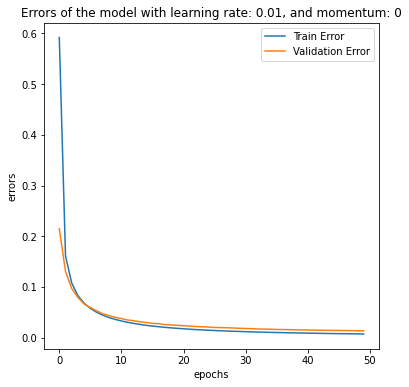

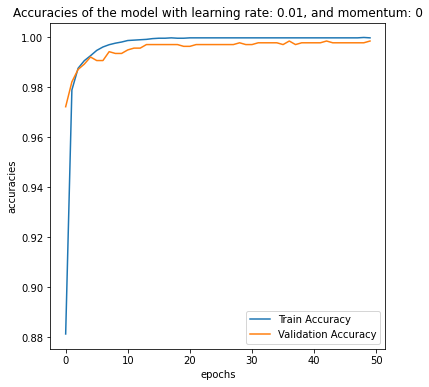

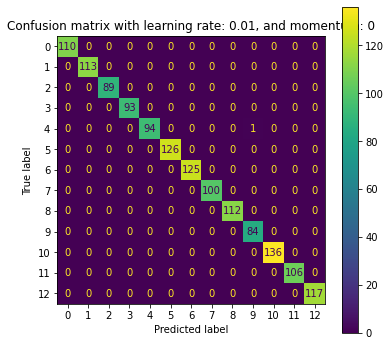

In [ ]:
learning_rate = 0.01
momentum = 0
# plot the errors
plot_errors(history.history, learning_rate, momentum)
# plot the accuracies
plot_accuracies(history.history, learning_rate, momentum)
# evaluate the model
evaluate_model(model, history, X_test, Y_test, learning_rate, momentum)

# show the plots
plt.show()

**Save the model to Google Drive**

In [ ]:
from keras.models import load_model

In [ ]:
# path to save the trained model
save_model_path = "/content/drive/MyDrive/IFN712_project/Hama_classification/Trained_models"

In [ ]:
model.save(os.path.join(save_model_path,'transfer_learning_train_by_HamaDataset_9372_images.h5'))

# **6. Test the trained model with a new image**

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
classes

['Hama_Fish',
 'Hama_Shushi_1',
 'Hama_Red_Duck',
 'Hama_Shushi_2',
 'Hama_Smile',
 'Hama_Panda',
 'Hama_Apple',
 'Hama_Pink_House',
 'Hama_Blue_Duck',
 'Hama_Bear',
 'Hama_Strawberry',
 'Hama_Yellow_Duck',
 'Hama_Sunglasses']

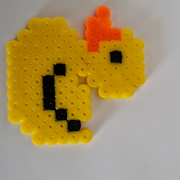

1/1 [==============================] - 0s 306ms/step
[[7.77864261e-05 2.11518022e-06 2.92453828e-04 1.10381116e-07
  3.30255875e-06 2.05871675e-05 4.83285658e-06 1.50622736e-06
  2.07910925e-04 4.54653709e-05 4.85332657e-06 9.99287307e-01
  5.18717570e-05]]
tf.Tensor(
[0.06795365 0.06794851 0.06796825 0.06794837 0.06794859 0.06794976
 0.06794869 0.06794847 0.06796249 0.06795146 0.06794869 0.1845712
 0.06795189], shape=(13,), dtype=float32)
This image most likely belongs to Hama_Yellow_Duck with a 18.46 percent confidence.


In [ ]:
img_path = "/content/drive/MyDrive/IFN712_project/Hama_classification/Hama_Test_images/Hama_Test_images24.jpg"

#display the image
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

# use this function to ensure that the image is scaled to [-1, 1]
img_array = prepare_image(img_path, IMAGE_SIZE)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)